## Text Analysis of Last Jedi Audience Reviews
This notebook assumes you have already scraped audience reviews from Rotten Tomatoes. This notebook will analyze frequence of ngrams and try some text classifiers.

In [5]:
#load libraries
import pandas as pd
import nltk
import os
import string
import re
from plotnine import *

In [2]:
#load the reviews file
os.chdir(r"O:\PDES\PRISM\Sullivan\Personal Projects")
reviewtbl = pd.read_csv("RT_Last_Jedi_2017-12-28.txt", sep="\t")

#check - well at least the export/import fixes some of my string issues
reviewtbl.head()

,userid,username,rating,text
0,840073561,['Jeffrey O'],2.5,"[""At least it was sort of original? Other than..."
1,977007867,['Claire R'],0.5,"[""The acting was great but the story writing w..."
2,976967449,['Caleb D'],0.5,['Would not recommend for so many reasons. Thi...
3,977007880,['James F'],0.5,['Horrible. Just watch any of the Youtube stuf...
4,977007877,['Michael C'],4.0,['Really good movie better than Force Awakens ...


## A quick summary of the data

        count        pct pct label
rating                            
0.5       396  38.976378       39%
1.0       134  13.188976       13%
1.5        71   6.988189        7%
2.0       100   9.842520       10%
2.5        45   4.429134        4%
3.0        42   4.133858        4%
3.5        17   1.673228        2%
4.0        40   3.937008        4%
4.5        37   3.641732        4%
5.0       134  13.188976       13%


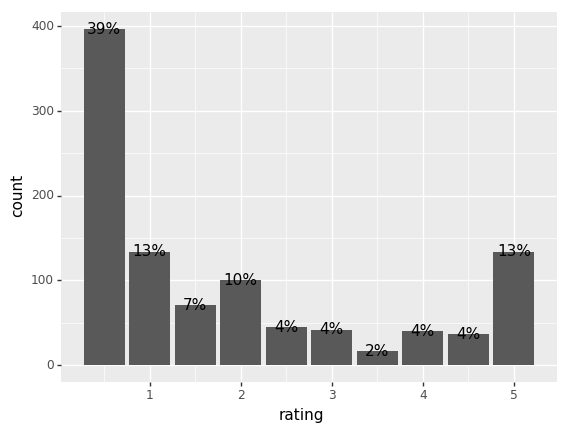

<ggplot: (26904342)>

In [35]:
labeldf = reviewtbl.groupby('rating')['userid'].agg(['count'])
labeldf['pct'] = (labeldf['count']/sum(labeldf['count']))*100
labeldf['pct label'] = ["{:.0f}%".format(x) for x in labeldf['pct']]
print(labeldf)
ggplot(labeldf.reset_index(), aes(x='rating', y='count')) + geom_bar(stat='identity') +geom_text(aes(label='pct label'))

In [3]:
#setup stop words
from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))
mywords = set(["star", "wars", "movie", "film", "wa", "last", "jedi"]) #'wa' to handle tokenizer's truncation of was
#add custom words
stop_words = set(stopwords.words('english')) | mywords

In [6]:
from nltk.stem.wordnet import WordNetLemmatizer

#clean and stem the review text
def txtclean(mytxt, stop_words, lmtzr):
    #convert to list of words
    tokens = nltk.word_tokenize(mytxt)
    
    #keep only alphanumreic
    words = [x for x in [re.sub("\W","",x) for x in tokens] if x.isalpha()]
    
    #lemmatize  - odd treatment of 'was' 
    std_words = [lmtzr.lemmatize(t) for t in words]
    
    #remove standard stop words (convert to lower) and return
    return [w for w in [x.lower() for x in std_words] if not w in stop_words]

#example
#txtclean(reviewtbl["text"][14], stop_words, WordNetLemmatizer())

['saw',
 'weekend',
 'afterwards',
 'really',
 'think',
 'lot',
 'mixed',
 'feeling',
 'lot',
 'thinking',
 'determined',
 'really',
 'liked',
 'different',
 'made',
 'lot',
 'bold',
 'choice',
 'opinion',
 'give',
 'credit',
 'lot',
 'thing',
 'unexpected',
 'really',
 'thought',
 'felt',
 'like',
 'really',
 'good',
 'idea',
 'acting',
 'good',
 'especially',
 'mark',
 'hamill',
 'carrie',
 'fisher',
 'comedy',
 'usually',
 'good',
 'visuals',
 'course',
 'good',
 'really',
 'enjoyed',
 'stuff',
 'rey',
 'luke',
 'part',
 'dragged',
 'subplot',
 'finn',
 'rose',
 'rose',
 'character',
 'care',
 'much',
 'even',
 'though',
 'low',
 'point',
 'terrible',
 'overall',
 'great',
 'feel',
 'fresh',
 'really',
 'think',
 'appreciate',
 'would',
 'say',
 'like',
 'one',
 'bit',
 'force',
 'awakens']

In [7]:
#put cleaned results back into a long string for use by sklearn
#testwrds = txtclean(reviewtbl["text"][14], stop_words, WordNetLemmatizer())
#" ".join(testwrds)

reviewtbl['clean text'] = [" ".join(txtclean(x, stop_words, WordNetLemmatizer())) for x in reviewtbl['text']]
reviewtbl.head()

,userid,username,rating,text,clean text
0,840073561,['Jeffrey O'],2.5,"[""At least it was sort of original? Other than...",least sort original story hoaky dialogue abysm...
1,977007867,['Claire R'],0.5,"[""The acting was great but the story writing w...",acting great story writing aweful know questio...
2,976967449,['Caleb D'],0.5,['Would not recommend for so many reasons. Thi...,would recommend many reason poorly written man...
3,977007880,['James F'],0.5,['Horrible. Just watch any of the Youtube stuf...,horrible watch youtube stuff skewering detail
4,977007877,['Michael C'],4.0,['Really good movie better than Force Awakens ...,really good better force awakens equal return ...


## Find words distinctive of negative reviews
We'll look at the relative frequency of words in positive (>=3.5 stars) and negative reviews as well as the relative frequency of words in 1/2 star reviews - in case there is something distinctive about those minimum reviews.

In [84]:
#method from stackoveflow
from sklearn.feature_extraction.text import CountVectorizer
def get_ngrams(corpus, nmin=1, nmax=2): #expects a column containing cleaned word lists
    word_vectorizer = CountVectorizer(ngram_range=(nmin,nmax), analyzer='word') #nmax+1 b/c range is not inclusive on right
    sparse_matrix = word_vectorizer.fit_transform(corpus)
    #transform matrix to array our total freq
    allngrams = pd.DataFrame(sum(sparse_matrix).toarray()[0], index=word_vectorizer.get_feature_names(), columns=['frequency'])
    #add n
    allngrams['n'] = [len(x.split()) for x in allngrams.index]
    #add relative corpus frequency
    allngrams['freq_rel'] = allngrams['frequency']/sum(allngrams['frequency'])
    #use binary property of CountVectorizer to get document requency
    doc_matrix = CountVectorizer(ngram_range=(nmin,nmax), analyzer='word', binary=True).fit_transform(corpus)
    allngrams['doc freq'] = sum(doc_matrix).toarray()[0]
    allngrams['doc freq_rel'] = allngrams['doc freq']/len(corpus)
    #returns a DataFrame with index=terms and columns for frequency in corpus, n, and relative freq in corpus
    return allngrams.sort_values('freq_rel', ascending=False)

In [85]:
#get ngrams for different types of reviews
positive_terms = get_ngrams(reviewtbl[reviewtbl["rating"]>=3.5]["clean text"])
negative_terms = get_ngrams(reviewtbl[reviewtbl["rating"]<3.5]["clean text"])
lowest_terms = get_ngrams(reviewtbl[reviewtbl["rating"]==0.5]["clean text"])

In [89]:
print(positive_terms.head())
print(negative_terms.head())
print(lowest_terms.head())
print(len(reviewtbl[reviewtbl["rating"]<3.5]["clean text"]))

           frequency  n  freq_rel  doc freq  doc freq_rel
nt               116  1  0.006889        64      0.280702
jedi              98  1  0.005820        55      0.241228
character         95  1  0.005642        56      0.245614
last              85  1  0.005048        53      0.232456
new               85  1  0.005048        57      0.250000
           frequency  n  freq_rel  doc freq  doc freq_rel
character        460  1  0.006506       267      0.338832
luke             352  1  0.004978       203      0.257614
nt               333  1  0.004710       184      0.233503
like             312  1  0.004413       187      0.237310
story            308  1  0.004356       200      0.253807
           frequency  n  freq_rel  doc freq  doc freq_rel
character        185  1  0.005859       107      0.270202
luke             167  1  0.005289       102      0.257576
nt               158  1  0.005004        91      0.229798
like             133  1  0.004212        98      0.247475
plot          

In [87]:
#terms that only appear in negative reviews
negunique = negative_terms.loc[set(negative_terms.index)-set(positive_terms.index)]
#add number of reviews the term(s) appear in - probably a more efficient scikit way to do this
#does this work correctly for n>2?
#negunique['doc freq'] = [sum([1 for review in reviewtbl['text'] if myterm in review]) for myterm in negunique.index]
negunique[negunique['n']>1].sort_values('freq_rel', ascending = False)

,frequency,n,freq_rel,doc freq,doc freq_rel
plot hole,91,2,0.001287,81,0.102792
worst ever,28,2,0.000396,27,0.034264
jar jar,21,2,0.000297,21,0.026650
many plot,19,2,0.000269,18,0.022843
story telling,16,2,0.000226,14,0.017766
waste time,16,2,0.000226,16,0.020305
plot line,16,2,0.000226,16,0.020305
mary poppins,16,2,0.000226,16,0.020305
one worst,15,2,0.000212,13,0.016497
disney ha,15,2,0.000212,15,0.019036


In [108]:
#terms in context
termtofind = 'plot line'
reviewtbl.loc[[myindex for myindex in reviewtbl.index if termtofind in reviewtbl.loc[myindex]['clean text']][0]]['text']

'[\'In my opinion this The Last Jedi fails on many different levels. Let me try to elaborate on this.\', \'1) IT FAILS AS A MOVIE IN GENERAL.\', \'The Last Jedi is fatally plagued by plot holes. Deus Ex Machinas, poor plot choices. The idea of the cat-and-mouse chase between the first order fleet and the rebels is not bad, but it is poorly executed. When watching the rebels slow escape I never felt a sense of impending danger and that caused a sense of detachment from the all situation. A similar plot device was used by Battlestar Galactica (the rebooted season) in a much more convincing way, because there the show manages to convey the threat of the pursuers. Additionally, the whole Casino plotline feels out of place, detached from the story and eventually usesless because it does not add anything to the story. The only thing it achieves is to break the pace pf the chase.\', "The jokes throughout the movie also felt out of place and put there just for their own sake. Seriously, was it

In [73]:
#method from stackoveflow
from sklearn.feature_extraction.text import CountVectorizer
word_vectorizer = CountVectorizer(ngram_range=(1,3), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(reviewtbl[reviewtbl["rating"]<3.5]["clean text"])
frequencies = sum(sparse_matrix).toarray()[0]
allngrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

In [83]:
#exploring sklearn method
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
idf_matrix = tfidf_transformer.fit_transform(sparse_matrix)
#pd.DataFrame(sum(idf_matrix).toarray()[0], index=word_vectorizer.get_feature_names(), columns=['frequency'])
#summing across idf matrix doesn't make much sense

,frequency
abandoned,0.525334
abandoned obviously,0.152184
abandoned obviously product,0.152184
abandoned order,0.110337
abandoned order facilitate,0.110337
abandoned previous,0.170434
abandoned previous luke,0.170434
abandoned training,0.029569
abandoned training yoda,0.029569
abandonment,0.234073


In [74]:
allngrams['n'] = [len(x.split()) for x in allngrams.index]
allngrams[allngrams['n']==2].sort_values('frequency', ascending=False)

,frequency,n
last jedi,139,2
force awakens,109,2
rian johnson,102,2
luke skywalker,97,2
plot hole,91,2
first order,46,2
original trilogy,44,2
character development,43,2
feel like,41,2
kylo ren,41,2


In [46]:
#scratch - testing nltk ngram approach
testwrds = txtclean(reviewtbl["text"][14], stop_words, WordNetLemmatizer())
bgs = nltk.bigrams(testwrds)

fdist = nltk.FreqDist(testwrds)
for k,v in fdist.items():
    print(k,v)

overall 1
bit 1
rey 1
weekend 1
rose 2
great 1
fresh 1
course 1
different 1
idea 1
even 1
appreciate 1
usually 1
mixed 1
low 1
think 2
point 1
awakens 1
carrie 1
star 2
subplot 1
mark 1
bold 1
though 1
opinion 1
felt 1
character 1
thinking 1
stuff 1
feel 1
luke 1
would 1
much 1
terrible 1
one 1
determined 1
movie 3
made 1
good 4
film 3
give 1
feeling 1
fisher 1
dragged 1
afterwards 1
like 2
wa 5
hamill 1
part 1
credit 1
finn 1
say 1
saw 1
choice 1
thought 1
especially 1
care 1
really 6
thing 1
unexpected 1
force 1
lot 4
wars 2
comedy 1
acting 1
liked 1
visuals 1
enjoyed 1
